# 📋 Quality Control of Single-Cell RNA-seq Data (Breast Cancer Dataset)

We perform quality control (QC) to remove low-quality cells from the breast cancer single-cell atlas.  
QC is based on per-cell total counts, number of genes detected, and MAD-based outlier detection.


In [1]:
# 📥 Load raw AnnData object
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import median_abs_deviation

adata = sc.read("../../data/breast_cancer_raw_annotated.h5ad")

print(f"✅ Loaded AnnData object: {adata.shape}")


✅ Loaded AnnData object: (35276, 47096)


## 🔍 Calculate QC Metrics

We calculate:
- Total counts (library size) per cell
- Number of genes detected per cell
- Log-transformed versions for stability


In [2]:
# 📊 Plot settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# 🧬 Convert to dense DataFrame
expr_df = adata.to_df()

# 📏 Calculate QC metrics
qc_df = pd.DataFrame(index=expr_df.index)
qc_df["total_counts"] = expr_df.sum(axis=1)
qc_df["n_genes"] = (expr_df > 0).sum(axis=1)
qc_df["log_total_counts"] = np.log1p(qc_df["total_counts"])
qc_df["log_n_genes"] = np.log1p(qc_df["n_genes"])

print(f"✅ Expression matrix shape: {expr_df.shape}")
qc_df.describe()

✅ Expression matrix shape: (35276, 47096)


,total_counts,n_genes,log_total_counts,log_n_genes
count,35276.000000,35276.000000,35276.000000,35276.000000
mean,10570.462552,3247.887601,9.119622,8.044494
std,7736.685309,1014.984088,0.492981,0.279635
min,3504.000000,1544.000000,8.161946,7.342779
25%,6210.000000,2513.000000,8.734077,7.829630
50%,8288.000000,2993.000000,9.022685,8.004366
75%,12071.000000,3716.000000,9.398644,8.220672
max,209637.000000,11995.000000,12.253138,9.392329


## 🧾 Determine Outliers with MAD-Based Thresholding

We define outliers as cells beyond 5 MADs from the median for both:
- log(total counts)
- log(number of genes)


In [3]:
# 🧾 Log MAD-based thresholds
def log_mad_thresholds(series, n_mads=5, label=""):
    med = np.median(series)
    mad = median_abs_deviation(series)
    low = med - n_mads * mad
    high = med + n_mads * mad
    print(f"📏 {label}: median={med:.2f}, MAD={mad:.2f}, low={low:.2f}, high={high:.2f}")

log_mad_thresholds(qc_df["log_total_counts"], 5, "log_total_counts")
log_mad_thresholds(qc_df["log_n_genes"], 5, "log_n_genes")


📏 log_total_counts: median=9.02, MAD=0.32, low=7.42, high=10.63
📏 log_n_genes: median=8.00, MAD=0.19, low=7.05, high=8.96


## 📊 Visualize QC Metrics

We plot:
- Total counts distribution
- Number of genes detected per cell
- Total counts vs number of genes


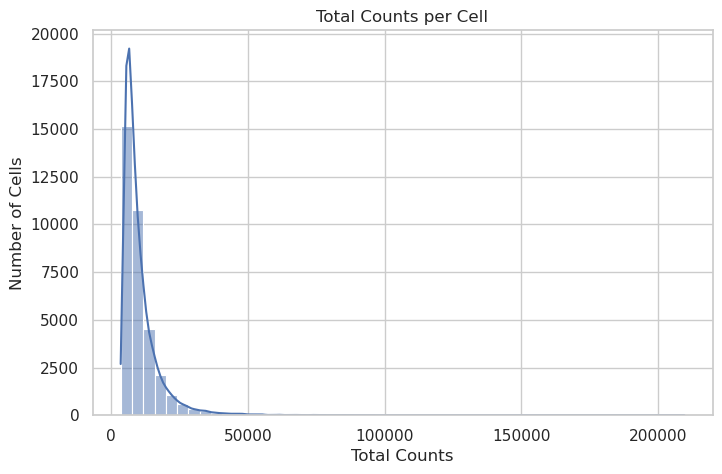

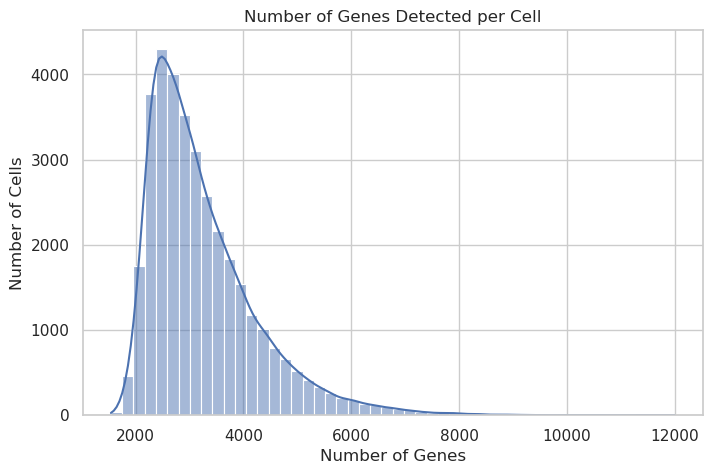

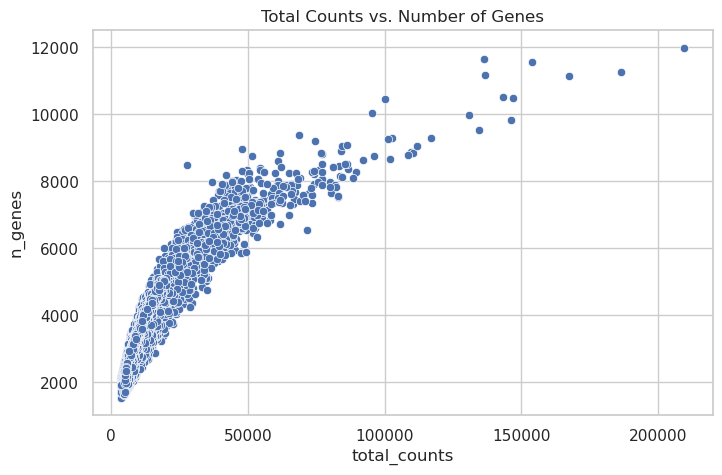

In [4]:
sns.histplot(qc_df["total_counts"], bins=50, kde=True)
plt.title("Total Counts per Cell")
plt.xlabel("Total Counts")
plt.ylabel("Number of Cells")
plt.show()

sns.histplot(qc_df["n_genes"], bins=50, kde=True)
plt.title("Number of Genes Detected per Cell")
plt.xlabel("Number of Genes")
plt.ylabel("Number of Cells")
plt.show()

sns.scatterplot(data=qc_df, x="total_counts", y="n_genes")
plt.title("Total Counts vs. Number of Genes")
plt.show()


## 🚨 Identify Outlier Cells

We mark cells as outliers if they deviate more than 5 MADs in any metric.


In [5]:
# 🚨 Identify outliers
def is_outlier(series, n_mads=5):
    med = np.median(series)
    mad = median_abs_deviation(series)
    return (series < med - n_mads * mad) | (series > med + n_mads * mad)

qc_df["outlier_counts"] = is_outlier(qc_df["log_total_counts"])
qc_df["outlier_genes"] = is_outlier(qc_df["log_n_genes"])
qc_df["is_outlier"] = qc_df[["outlier_counts", "outlier_genes"]].any(axis=1)

print(f"⚠️ Number of cells flagged as outliers: {qc_df['is_outlier'].sum()}")


⚠️ Number of cells flagged as outliers: 331


## 🧹 Filter Out Low-Quality Cells

Cells flagged as outliers are removed from the dataset.


In [6]:
# 🧹 Filter cells
filtered_adata = adata[~qc_df["is_outlier"]].copy()

print(f"✅ Filtered AnnData object: {filtered_adata.shape}")

# 💾 Save the clean dataset
filtered_adata.write("../../data/breast_cancer_qc_filtered.h5ad")
print("📁 Saved QC-filtered dataset to 'breast_cancer_qc_filtered.h5ad'")


✅ Filtered AnnData object: (34945, 47096)
📁 Saved QC-filtered dataset to 'breast_cancer_qc_filtered.h5ad'
